In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive, files
drive.mount('/content/drive/')
path = "drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
x_train_gray = pickle.load(open(path + 'x_train_gray.P', mode='rb'))
x_val_gray = pickle.load(open(path + 'x_val_gray.P', mode='rb'))

AUTOENCODER
- convolutional autoencoder.
- reshape layer to get the coding variable

In [27]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

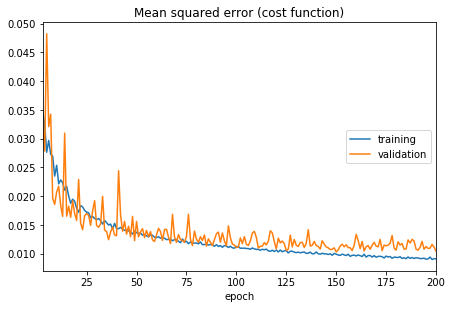

Mean squared error (cost function):
training   (min:    0.009, max:    0.071, cur:    0.009)
validation (min:    0.010, max:    0.051, cur:    0.010)


In [59]:
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Reshape,Flatten,Dense
from keras.models import Model

batch_size = 32
epochs = 200
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))

x_train_gray = np.reshape(x_train_gray,(-1,64,64,1))
x_val_gray = np.reshape(x_val_gray,(-1,64,64,1))
    
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3) 
    
    #flat1 = Flatten()(conv4)
    #dense1 = Dense(512, activation='relu')(flat1)
    #resh2 = Reshape((8,8,8))(dense1)

    #decoder
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = 'rmsprop')
autoencoder_train = autoencoder.fit(x_train_gray, 
                                    x_train_gray, 
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val_gray, x_val_gray),
                                    callbacks=[PlotLossesKeras()])

In [0]:
output = autoencoder.predict(x_val_gray)

In [0]:
output_resh = np.reshape(output,(-1,64,64))
x_val_gray_resh = np.reshape(x_val_gray,(-1,64,64))

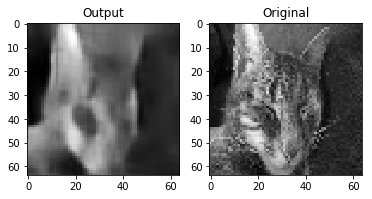

In [62]:
plt.subplot(121)
plt.title('Output')
plt.imshow(output_resh[0], cmap='gray')
plt.subplot(122)
plt.title('Original')
plt.imshow(x_val_gray_resh[0], cmap='gray')

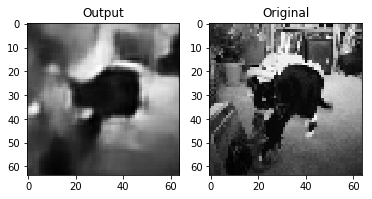

In [63]:
plt.subplot(121)
plt.title('Output')
plt.imshow(output_resh[20], cmap='gray')
plt.subplot(122)
plt.title('Original')
plt.imshow(x_val_gray_resh[20], cmap='gray')

In [0]:
autoencoder.save('autoencoder.h5')